### Test trained model on unseen data

In [1]:
# Basic setup
import os
os.chdir('../')
import logging
import numpy as np
import pytorch_lightning as pl
import pandas as pd
import scanpy as sc
logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
%load_ext autoreload
%autoreload 0

# assign number of cpus to use as data loaders
n_cpus = 10
seed = 42

# define label in .obs to classify
cls_label = 'cls_label'
batch_key = 'dataset'

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

In [2]:
# Set model and training data paths
version_dir = '/home/xlv0877/proj_home/dl/models/run7/rl+kl+ce/lightning_logs/version_13'.rstrip('/')
model_dir = os.path.join(version_dir, 'model')
adata_p = '/home/xlv0877/proj_home/dl/data/model_set.h5ad'
latent_p = os.path.join(version_dir, 'latent.h5ad')

#### Load pre-trained model

In [3]:
from src.models._jedvi import JEDVI

adata = sc.read(adata_p)
model = JEDVI.load(model_dir, adata)
model

INFO     File /home/xlv0877/proj_home/dl/models/run7/rl+kl+ce/lightning_logs/version_13/model/model.pt already     
         downloaded                                                                                                


2025-07-08 17:01:55,219 - INFO - Converting adata.X to csr matrix to boost training efficiency.


<class 'src.models._jedvi.JEDVI'> Model with the following params: 
n_classes: 100, 
Training status: Trained

#### Load test data

In [159]:
test_p = '/home/xlv0877/proj_home/dl/data/test.h5ad'
test_ad = sc.read(test_p)

In [160]:
shared_perturbations = set(adata.obs.perturbation.unique()).intersection(test_ad.obs.perturbation.unique())
logging.info(f'Found {len(shared_perturbations)} shared perturbations between training and testing.')

2025-07-08 15:24:28,819 - INFO - Found 27 shared perturbations between training and testing.


In [161]:
# Polish data TODO: take datasets from pipeline (will be in correct format so this is not needed)
# Remove control class from adata
test_ad._inplace_subset_obs(test_ad.obs.perturbation!='control')

In [162]:
# define all labels to classify on
if 'perturbation_direction' in adata.obs.columns:
    logging.info('Using perturbation direction to classify')
    cls_labels = ['perturbation_direction', 'perturbation']
else:
    cls_labels = ['celltype', 'perturbation_type', 'perturbation']
# define label in .obs to classify
cls_label = 'cls_label'
batch_key = 'dataset'
# create classification label
test_ad.obs[cls_label] = test_ad.obs[cls_labels].agg(';'.join, axis=1)
test_ad.obs[batch_key] = 'ReplogleWeissman2022_K562_gwps'
test_ad.obs['celltype'] = 'lymphoblasts'

2025-07-08 15:24:29,754 - INFO - Using perturbation direction to classify


In [163]:
# Init test dataset with pre-trained model
model.setup_anndata(
    test_ad, labels_key=cls_label,
    batch_key=batch_key,
    categorical_covariate_keys=['celltype']
)

2025-07-08 15:24:29,895 - INFO - Converting adata.X to csr matrix to boost training efficiency.


In [164]:
# Create compatible test data for trained model
test_ad = model.create_test_data(test_ad)

2025-07-08 15:24:41,254 - INFO - Found 54 missing features in test data. Setting them to 0.


In [165]:
# Get latent representation of test data
test_ad.obsm['latent_z'] = model.get_latent_representation(adata=test_ad)

2025-07-08 15:24:42,809 - INFO - Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup


In [ ]:
%reload_ext autoreload
%autoreload 0

In [192]:
predictions, cz = model.predict(adata=test_ad, return_latent=True, soft=True)

2025-07-08 16:14:09,495 - INFO - Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup


In [199]:
test_ad.obs['cls_prediction'] = soft_predictions.columns[soft_predictions.values.argmax(axis=-1)]

In [182]:
common_classes = soft_predictions.columns.intersection(predictions.columns).sort_values()

In [200]:
from src.plotting import get_classification_report
# Get classification report
summary, report = get_classification_report(test_ad, cls_label=cls_label, mode='test')

In [202]:
report[report.index.isin('neg;'+pd.Series(list(shared_perturbations)).astype(str))].sort_values('f1-score', ascending=False)

,precision,recall,f1-score,support,log_count,mode
neg;VPS41,0.013158,0.042408,0.020084,731.0,6.594413,test
neg;PRODH,0.012812,0.043663,0.019812,939.0,6.844815,test
neg;ANAPC15,0.015806,0.013749,0.014706,1091.0,6.994850,test
neg;SLC1A5,0.010112,0.020690,0.013585,870.0,6.768493,test
neg;SLC39A9,0.020000,0.010000,0.013333,800.0,6.684612,test
neg;DDX19B,0.007474,0.020776,0.010993,722.0,6.582025,test
neg;PSMG3,0.011050,0.007585,0.008996,791.0,6.673298,test
neg;CADM4,0.008872,0.008284,0.008568,845.0,6.739337,test
neg;CACNB3,0.006135,0.012075,0.008136,911.0,6.814543,test
neg;DPH1,0.006944,0.008708,0.007727,689.0,6.535241,test


In [134]:
latent.obs['cls_score'] = np.max(soft_predictions, axis=1) - np.mean(soft_predictions, axis=1)

... storing 'cls_prediction' as categorical


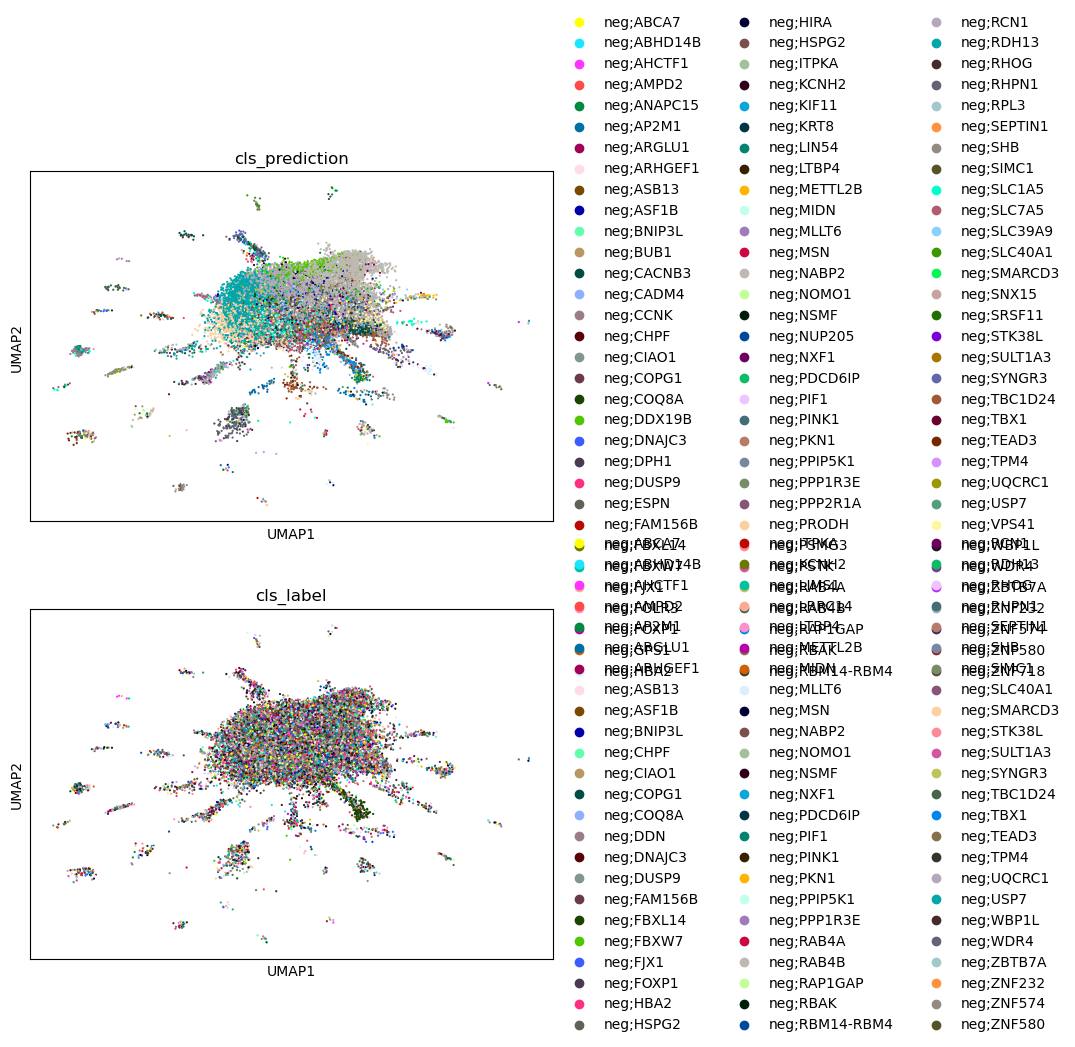

In [138]:
tmp = latent[(latent.obs['mode']=='test') & ~(latent.obs.perturbation.isin(shared_perturbations))].copy()
sc.pl.umap(tmp, color=['cls_prediction', 'cls_label'], s=10, ncols=1)

... storing 'zoom' as categorical


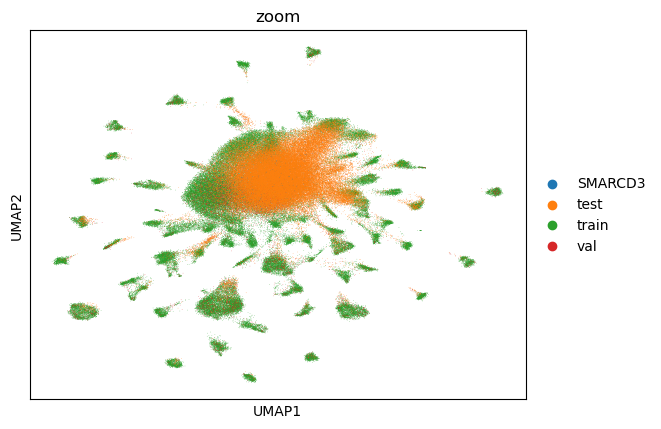

In [20]:
target = 'SMARCD3'
tmp = latent.copy()
tmp.obs['zoom'] = tmp.obs['mode'].astype(str)
tmp.obs.loc[tmp.obs.perturbation==target,'zoom'] = target
sc.pl.umap(tmp, color='zoom')

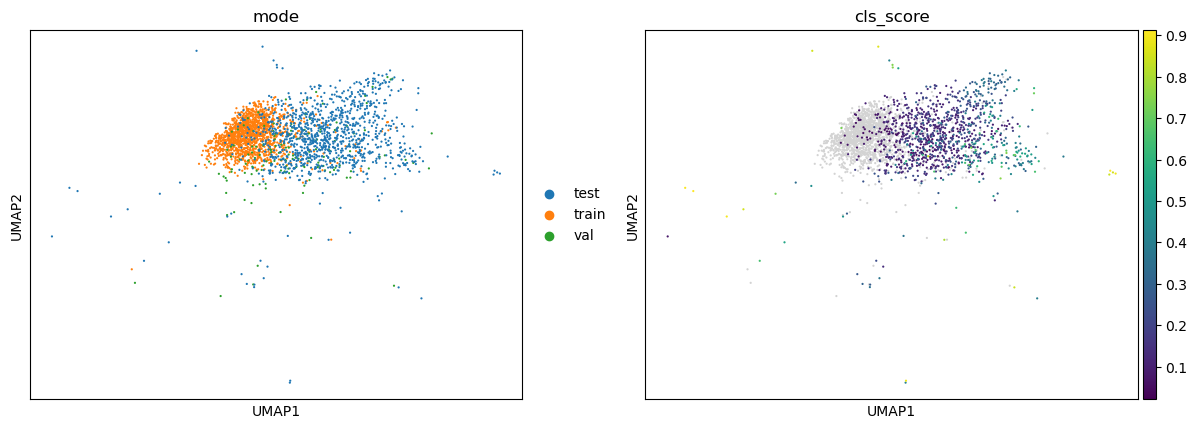

In [21]:
tmp = latent[latent.obs.perturbation=='ANAPC15'].copy()
sc.pl.umap(tmp, color=['mode', 'cls_score'], s=10)

In [77]:
adata.uns['cls_embedding']

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 304128 stored elements and shape (99, 3072)>

In [63]:
# Check gene embedding for missing genes
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


shared_mask = test_ad.uns['cls_embedding'].index.str.split(';').str[1].isin(shared_perturbations)
X = test_ad.uns['cls_embedding'].copy()
idx = test_ad.uns['cls_embedding'].index
X = StandardScaler().fit_transform(X)
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [64]:
pl_df = pd.DataFrame(X_pca, index=idx, columns=['PC_1', 'PC_2'])
pl_df['in_model'] = False
pl_df.loc[shared_mask,'in_model'] = True

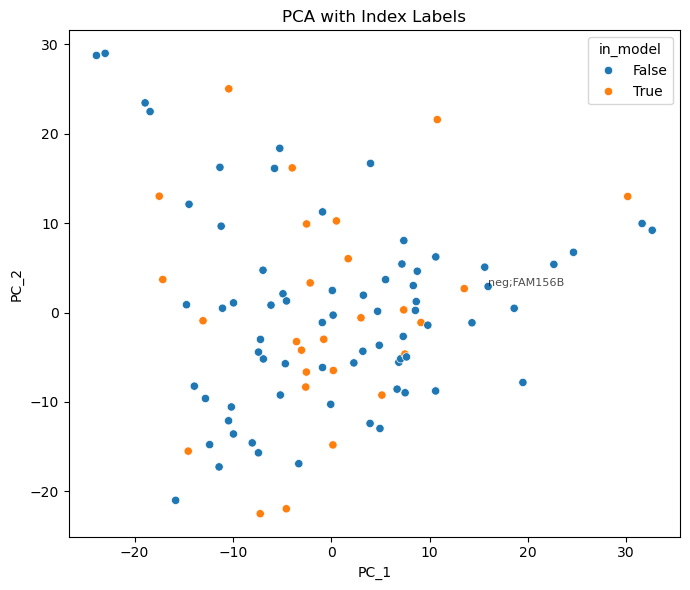

In [74]:
# Plot pca of embedding space
fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(pl_df, x='PC_1', y='PC_2', hue='in_model', ax=ax)
# Add index labels to each point
ann_df = pl_df[pl_df.index.str.startswith('neg;FAM')]
for i, row in ann_df.iterrows():
    ax.text(
        row['PC_1'] + 0.01,  # x position (add small offset to avoid overlap)
        row['PC_2'] + 0.01,  # y position
        str(i),              # the index of the row
        fontsize=8,
        alpha=0.7
    )

plt.title("PCA with Index Labels")
plt.tight_layout()
plt.show()

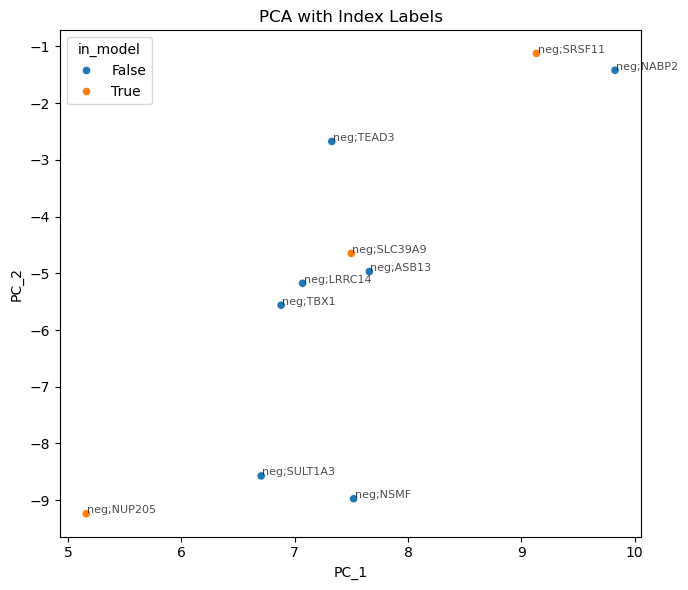

In [66]:
zoom_mask = (pl_df['PC_1'] > 5) & (pl_df['PC_1'] < 10) & (pl_df['PC_2'] > -10) & (pl_df['PC_2'] < 0)
zoom_df = pl_df[zoom_mask]

In [39]:
report_mask = (report.support > 0) & ~(report.index.isin('neg;' + pd.Series(list(shared_perturbations)).astype(str)))
report[report_mask].sort_values('f1-score', ascending=False)

,precision,recall,f1-score,support,log_count,mode
neg;SMARCD3,0.0,0.0,0.0,565.0,6.336826,test
neg;STK38L,0.0,0.0,0.0,1169.0,7.063904,test
neg;SULT1A3,0.0,0.0,0.0,843.0,6.736967,test
neg;SYNGR3,0.0,0.0,0.0,575.0,6.354370,test
neg;TBC1D24,0.0,0.0,0.0,565.0,6.336826,test
...,...,...,...,...,...,...
neg;AMPD2,0.0,0.0,0.0,616.0,6.423247,test
neg;AP2M1,0.0,0.0,0.0,572.0,6.349139,test
neg;ARGLU1,0.0,0.0,0.0,673.0,6.511745,test
neg;ARHGEF1,0.0,0.0,0.0,607.0,6.408529,test


In [ ]:
from src.plotting import predict_novel, plot_model_results_mode, get_latest_tensor_dir
# Predict novel
test_ad.obs['perturbation_type'] = 'CRISPRi'
logging.info('Running model with novel test data.')
plt_dir = os.path.join(version_dir, 'plots')
predict_novel(gedvae, test_adata, 'cls_label', out_dir=version_dir, batch_key='dataset', emb_key=None)